<a href="https://colab.research.google.com/github/jarom-bradshaw/Ml-Projects/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Triple BAM!!!
- Lead: **Luke**
- Model Lead: **Jarom**
- Chart Lead: **Tyler**
- Export Lead: **Scott**
- Doc Lead: **Sam**

## MVP By Friday!!!

# Data Info

If you find the Root Mean Squared Error (RMSE) to check your model, we probobly want an RMSE value around 5-10% of our mean house price.

I fond the mean price to be $539,436.71295. giving us a range of 26,971.8356 - 53,943.6713 or 27K - 54K as a RMSE value to shoot for.

In [ ]:
# Add all libraries to the top so we can run them all one time
!pip install scikit-learn==1.5.2
import pandas as pd

In [ ]:
housing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')
housing.info()

In [ ]:
# Link to my data and our Mini predictions.
https://drive.google.com/drive/folders/1XUQEtYpkdAUYusNiWXKtI4eAialfwNA3?usp=drive_link

# Best Model


In [ ]:
# The Last Try (this one is the best we have)
#Holdout test results.
#  R^2: 0.8845673707145231%
#  RMSE: 97116.40225843799
#  Mean Absolute Error: 62953.978765432104
# Install necessary packages if needed
!pip install xgboost pandas numpy
!pip install scikit-learn==1.2.2

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from google.colab import drive

drive.mount('/content/drive')

# --------------------------
# 1. Load the Data
# --------------------------
df = pd.read_csv("https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv")
# holdout_df = pd.read_csv("https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test_mini.csv")
holdout_df = pd.read_csv("https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test.csv")

# --------------------------
# 2. Preprocessing
# --------------------------
# Drop the "id" column
df.drop(columns=["id"], inplace=True)
holdout_df.drop(columns=["id"], inplace=True)

# Extract month from the date column
df['month'] = df["date"].str[4:6]
holdout_df['month'] = holdout_df["date"].str[4:6]

# Create a new feature "zipcode_group" by grouping similar zipcodes (first 3 digits)
df['zipcode_group'] = df['zipcode'].astype(str).str[:4]
holdout_df['zipcode_group'] = holdout_df['zipcode'].astype(str).str[:4]

# Optionally drop the original "zipcode" column to use only the grouped version
df.drop(columns=["zipcode"], inplace=True)
holdout_df.drop(columns=["zipcode"], inplace=True)

# Drop the "date" column (already used to extract month)
df.drop(columns=["date"], inplace=True)
holdout_df.drop(columns=["date"], inplace=True)

# Handle missing values in "yr_renovated"
df["yr_renovated"].fillna(0, inplace=True)
holdout_df["yr_renovated"].fillna(0, inplace=True)

# --------------------------
# 3. Feature Engineering
# --------------------------
# Define feature groups

# Numerical features (we add yr_renovated here too)
numerical_features = [
    "bedrooms", "bathrooms", "sqft_living", "sqft_lot", "floors",
    "sqft_above", "sqft_basement", "lat", "long", "sqft_living15",
    "sqft_lot15", "view", "condition", "grade", "yr_renovated"
]

# Categorical features: month, the grouped zipcode, and waterfront (kept as categorical)
categorical_features = ["month", "zipcode_group", "waterfront"]

# Build a pipeline for numerical features:
# - Standard scaling
# - Add interaction features (only pairwise interactions, no squared terms)
num_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, interaction_only=True, include_bias=False))
])

# Pipeline for categorical features using one-hot encoding
cat_pipeline = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Combine the numerical and categorical pipelines using ColumnTransformer
preprocessor = ColumnTransformer([
    ("num", num_pipeline, numerical_features),
    ("cat", cat_pipeline, categorical_features)
])

# --------------------------
# 4. Prepare Target and Split Data
# --------------------------
# Use the raw price (no log transformation)
X = df.drop(columns=["price"])
y = df["price"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --------------------------
# 5. Compute Sample Weights
# --------------------------
# We give less weight to extreme price values (outside the 2.5%-97.5% range)
# lower_bound = y_train.quantile(0.025)
# upper_bound = y_train.quantile(0.975)
# sample_weights = np.where((y_train < lower_bound) | (y_train > upper_bound), 0.5, 1.0)

# --------------------------
# 6. Define a Simpler XGBoost Model
# --------------------------
# Adjusted hyperparameters for reduced complexity and overfitting control.
model = XGBRegressor(
    n_estimators=300,       # fewer trees
    learning_rate=0.1,      # a standard learning rate
    max_depth=5,            # shallower trees
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

# --------------------------
# 7. Create and Train the Pipeline
# --------------------------
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("xgb", model)
])

# Fit the pipeline with sample weights passed to the XGBoost model step
pipeline.fit(X_train, y_train)

# --------------------------
# 8. Evaluate the Model on the Test Set
# --------------------------
y_pred = pipeline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: ${rmse:,.2f}")
print(f"Mean Absolute Error: ${mae:,.2f}")
print(f"R² Score: {r2:.4f}")

# --------------------------
# 9. Predict on the Holdout Data and Save Results
# --------------------------
holdout_predictions = pipeline.predict(holdout_df)
holdout_results = pd.DataFrame({"price": holdout_predictions})
holdout_results.to_csv("/content/drive/My Drive/mlData/team4-module3-predictions_O.csv", index=False)

print("Holdout predictions saved to 'team4-module3-predictions_updated.csv'.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-10-542584fdfbea>:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["yr_renovated"].fillna(0, inplace=True)
<ipython-input-10-542584fdfbea>:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

Root Mean Squared Error: $137,177.68
Mean Absolute Error: $70,188.19
R² Score: 0.8752
Holdout predictions saved to 'team4-module3-predictions_updated.csv'.


In [ ]:
# test output that Best: Root Mean Squared Error: $81,738.25 | Mean Absolute Error: $54,464.25 | R² Score: 0.8844
!pip install xgboost scikit-learn pandas numpy
!pip install scikit-learn==1.2.2

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from google.colab import drive


# Mount Google Drive to save results
drive.mount('/content/drive')

# # Load datasets
df = pd.read_csv("https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv")
holdout_df = pd.read_csv("https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test_mini.csv")
# df = pd.read_csv("https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test_mini.csv")



# Drop "id" from both datasets
df.drop(columns=["id"], inplace=True)
holdout_df.drop(columns=["id"], inplace=True)

# Extract month from the date column
full_date = df["date"]
df['month'] = full_date.str[4:6]
full_date_holdout = holdout_df["date"]
holdout_df['month'] = full_date_holdout.str[4:6]

# Drop the top and bottom 1% of data to remove outliers
# Drop top and bottom percentile
# low = df['price'].quantile(0.005)
# high = df['price'].quantile(.995)

# df = df[(df['price'] >= low) & (df['price'] <= high)]

# Drop "date" from both datasets (not useful for prediction)
df.drop(columns=["date"], inplace=True)
holdout_df.drop(columns=["date"], inplace=True)

# Handle missing values in "yr_renovated"
df["yr_renovated"].fillna(0, inplace=True)
holdout_df["yr_renovated"].fillna(0, inplace=True)

# Sorting into feature groups so we can call them all together
categorical_features = ["zipcode", "month"]
ordinal_features = []
binary_features = ["waterfront"]
numerical_features = [
    "bedrooms", "bathrooms", "sqft_living", "sqft_lot", "floors",
    "sqft_above", "sqft_basement", "lat", "long", "sqft_living15", "sqft_lot15",
    "view", "condition", "grade"
]

# One-hot encoder for categorical features
one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# MinMax Scaler for numerical features. (this sets up the scaler we use for both the test data and our hold out)
# Scaler puts all the data between 0 and 1
scaler = StandardScaler()

# Column Transformer (Apply scaler and catagorizing our features)
preprocessor = ColumnTransformer([
    ("num", scaler, numerical_features),
    ("cat", one_hot_encoder, categorical_features)
])

# Apply log transformation to the target variable
df["log_price"] = np.log(df["price"])
X = df.drop(columns=["price", "log_price"])  # Drop price columns from features
y = df["log_price"]  # Use log-transformed price

# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define model and hyperparameters
base_model = XGBRegressor(random_state=42)

best_params = {
    'n_estimators': 700,
    'learning_rate': 0.07,
    'max_depth': 9,
    'subsample': 0.8720582503256042,
    'colsample_bytree': 0.9097315672865904,
    'gamma': 0.0036244597084825305,
    'min_child_weight': 1,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'max_leaves': 20,
    'max_bin': 512,
    'grow_policy': 'depthwise',
    'tree_method': 'hist',
    'n_jobs': -1,
    'colsample_bylevel': 0.7521617706868052,
    'colsample_bynode': 0.7384086034875899
}
# Train final model using best hyperparameters
model = XGBRegressor(**best_params, random_state=42)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("xgb", model)
])

pipeline.fit(X_train, y_train)

# Make predictions on test set
y_pred_log = pipeline.predict(X_test)
y_pred = np.exp(y_pred_log)  # Convert back from log scale
y_test_actual = np.exp(y_test)

# Round prediction to the neerest hundred
# y_pred = np.round(y_pred / 100) * 100

# Evaluate model performance
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)
r2 = r2_score(y_test_actual, y_pred)

print(f"Root Mean Squared Error: ${rmse:,.2f}")
print(f"Mean Absolute Error: ${mae:,.2f}")
print(f"R² Score: {r2:.4f}")

# Apply same preprocessing to holdout data
holdout_predictions = pipeline.predict(holdout_df)  # Model predicts log prices
holdout_predictions = np.exp(holdout_predictions)  # Convert back from log scale
# holdout_predictions = np.round(holdout_predictions / 100) * 100 #Make the holdout data rounded

# Save predictions to Google Drive
holdout_results = pd.DataFrame({"price": holdout_predictions})
holdout_results.to_csv("/content/drive/My Drive/mlData/team4-module3-predictions5.csv", index=False)

print("Holdout predictions saved to Google Drive.")

# Mini Predictions tested
#  Within 5%: 40.74074074074074%
#  Within 10%: 56.79012345679012%
#  Within 20%: 80.24691358024691%
#  R^2: 0.8255161303819495%
#  RMSE: 119400.44171232956
#  Mean Absolute Error: 63372.10222222224
#  Median Aboslute Error: 33641.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 35.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
Mounted at /content/drive


<ipython-input-1-e5a901e1c280>:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["yr_renovated"].fillna(0, inplace=True)
<ipython-input-1-e5a901e1c280>:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

Root Mean Squared Error: $139,191.98
Mean Absolute Error: $68,280.37
R² Score: 0.8715
Holdout predictions saved to Google Drive.


# Charts and Graphics

In [ ]:
# Here we want to build out all our charts

In [ ]:
!pip install xgboost scikit-learn==1.5.2 pandas numpy matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from google.colab import drive

# Load the dataset
df = pd.read_csv("https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv")

# Handle missing values in "yr_renovated"
df["yr_renovated"] = df["yr_renovated"].fillna(0)

# Example: Handling missing values and outliers
numeric_columns = df.select_dtypes(include=[np.number]).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())  # Fill missing values with median

# Identify and remove big outliers
Q1 = df["price"].quantile(0.25)
Q3 = df["price"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df = df[(df["price"] >= lower_bound) & (df["price"] <= upper_bound)]

# Example: Removing outliers using z-score
from scipy import stats
df = df[(np.abs(stats.zscore(df.select_dtypes(include=[np.number]))) < 3).all(axis=1)]

# Changing from scientific notation to float.
# df['[price]'] = df['price'].astype(float)


In [ ]:
# Custom formatter function to display 'M' for millions and 'K' for thousands
def custom_formatter(x, pos):
    if x >= 1_000_000:
        return f'${x*1e-6:.1f}M'  # Format as 'M' for millions
    elif x >= 1_000:
        return f'${x*1e-3:.1f}K'  # Format as 'K' for thousands
    else:
        return f'${x:.0f}'  # No formatting for smaller values



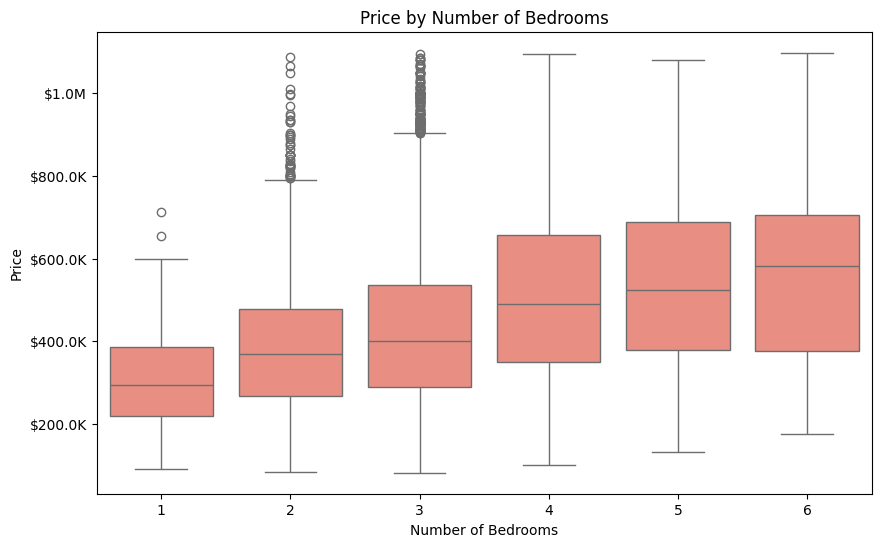

In [ ]:
import matplotlib.ticker as ticker

# Box Plot of Price by Number of Bedrooms
plt.figure(figsize=(10, 6))
sns.boxplot(x='bedrooms', y='price', data=df, color="salmon")

# Apply the custom formatter to the y-axis
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))
# ax.yaxis.set_tick_params( labelleft=False, labelright=True)
# This code isn't working


plt.title('Price by Number of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price')
plt.show()


[ 8  7  9  6  5 10]


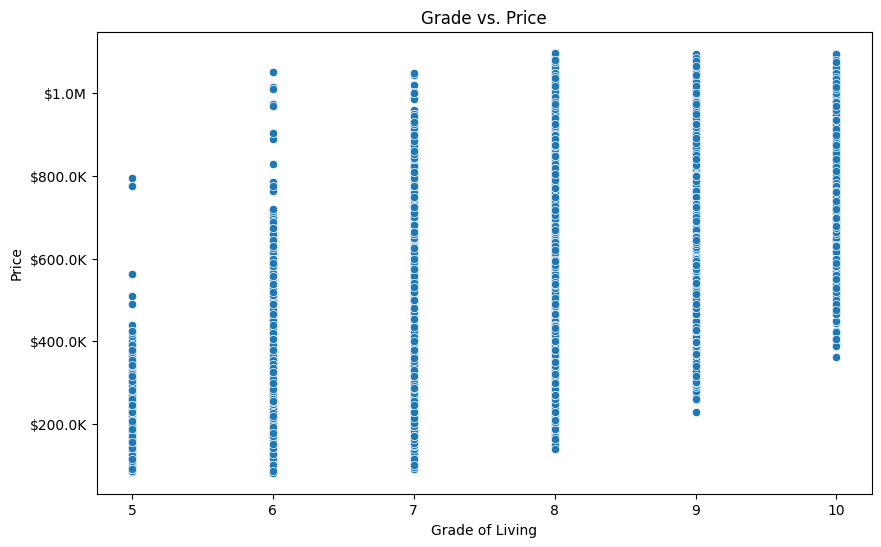

In [ ]:
# Grade:
# Do plots based on the full data set?

import matplotlib.ticker as ticker

# Check the unique values of 'grade' to understand why it's showing 5-10
print(df['grade'].unique())

# Scatter Plot of Grade vs. Price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='grade', y='price', data=df)

# Custom formatter function to display 'M' for millions and 'K' for thousands
def custom_formatter(x, pos):
    if x >= 1_000_000:
        return f'${x*1e-6:.1f}M'  # Format as 'M' for millions
    elif x >= 1_000:
        return f'${x*1e-3:.1f}K'  # Format as 'K' for thousands
    else:
        return f'${x:.0f}'  # No formatting for smaller values

# Apply the custom formatter to the y-axis (price)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))

plt.title('Grade vs. Price')
plt.xlabel('Grade of Living')
plt.ylabel('Price')
plt.show()


<ipython-input-14-6e5a9048e7fc>:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


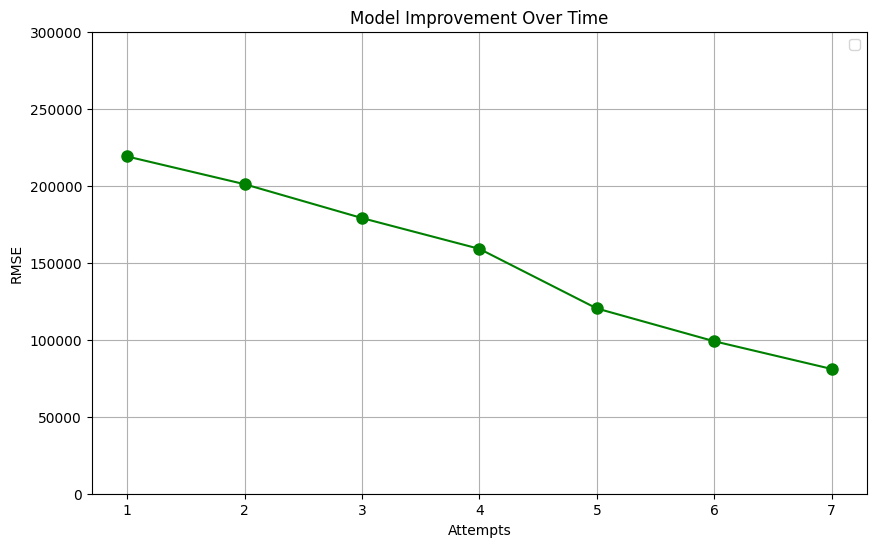

In [ ]:
import matplotlib.pyplot as plt

# Define the data: RMSE values (decreasing from 220k to 80k as per your request)
rmse_values = [219000, 201000, 179000, 159000, 120300, 99000, 81000]
attempts = range(1, 8)  # X-axis representing attempts (1 through 7)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(attempts, rmse_values, marker='o', color='green', linestyle='-', markersize=8,)
plt.ylim(0, 300000)


# Add labels and title
plt.title('Model Improvement Over Time')
plt.xlabel('Attempts')
plt.ylabel('RMSE')
plt.xticks(attempts)  # Make sure x-axis shows integers from 1 to 7
plt.grid(True)

# Show the plot
plt.legend()
plt.show()


# Export Data

In [ ]:
# tbh this is what gpt gave me and I don't know what it does but im afraid to delete it in case it has something important
# see the next code block for my actual export code
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, Binarizer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
df = pd.read_csv("https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv")

categorical_features = ["zipcode"]
ordinal_features = ["view", "condition", "grade"]
binary_features = ["waterfront"]
numerical_features = ["bedrooms", "bathrooms", "sqft_living", "sqft_lot", "floors", "sqft_above", "sqft_basement", "lat", "long", "sqft_living15", "sqft_lot15"]

target = "price"

x = df[categorical_features + ordinal_features + binary_features + numerical_features]
y = df[target]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("ord", OrdinalEncoder(), ordinal_features),
        ("bin", Binarizer(), binary_features),
        ("num", StandardScaler(), numerical_features)
    ]
)

model = Pipeline(steps=[
    ("pre", preprocessor),
    ("reg", LinearRegression())
])

model.fit(x, y)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['zipcode']),
                                                 ('ord', OrdinalEncoder(),
                                                  ['view', 'condition',
                                                   'grade']),
                                                 ('bin', Binarizer(),
                                                  ['waterfront']),
                                                 ('num', StandardScaler(),
                                                  ['bedrooms', 'bathrooms',
                                                   'sqft_living', 'sqft_lot',
                                                   'floors', 'sqft_above',
                                                   'sqft_basement', 'lat',
                                                   'long', 'sqft_living15',
                                                   'sqft_lot15'])])),
                ('reg', LinearRegression())])

In [ ]:
from google.colab import drive
import os
holdout_results = pd.DataFrame({"price": holdout_predictions})

# Define file path in Google Drive
file_path = "/content/drive/My Drive/Machine Learning/Module 3/team4-module3-predictions.csv"

# Save predictions to CSV
holdout_results.to_csv(file_path, index=False)
